In [2]:
import sympy as sp

s, lam = sp.symbols('s lam', positive=True)
A = s+lam
u, q = sp.symbols('u q')
S = (s+u) / (s + lam + 2*u + q)
# series expansion up to second order in u and q treating u~O(eps), q~O(eps**2)
# Using multivariate series: expand and truncate by setting higher-order terms to zero manually
expansion = sp.series(S, u, 0, 3).removeO()
# But this series treats q constant; then we can expand that expression for q small too.
expansion_u = expansion.expand()
expansion_u


4*s*u**2/(lam**3 + 3*lam**2*q + 3*lam**2*s + 3*lam*q**2 + 6*lam*q*s + 3*lam*s**2 + q**3 + 3*q**2*s + 3*q*s**2 + s**3) - 2*s*u/(lam**2 + 2*lam*q + 2*lam*s + q**2 + 2*q*s + s**2) + s/(lam + q + s) - 2*u**2/(lam**2 + 2*lam*q + 2*lam*s + q**2 + 2*q*s + s**2) + u/(lam + q + s)

In [3]:
# Re-create the package and analysis script, then verify by importing and doing a tiny test run.
import os, textwrap, pathlib, torch, pandas as pd

# Quick smoke test: import and run a tiny simulation
import sys
sys.path.append(".")
from traversal_sim import run_simulation

# Minimal toy objects copied inline (so we can test quickly)
class GaussianX:
    def __init__(self, d, device="cpu", dtype=torch.float64):
        self.d=d; self.device=device; self.dtype=dtype
        self._L = torch.eye(d, dtype=dtype, device=device)
    def sample(self, n):
        z = torch.randn(n, self.d, dtype=self.dtype, device=self.device)
        return z @ self._L.T

class TrueLinear(torch.nn.Module):
    def __init__(self, w, b=0.0):
        super().__init__()
        self.w = torch.nn.Parameter(w.clone().detach(), requires_grad=False)
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=w.dtype, device=w.device), requires_grad=False)
    def forward(self, X):
        return X @ self.w + self.b

d=5
X_dist = GaussianX(d=d)
w_true = torch.arange(1, d+1, dtype=torch.float64)
f_true = TrueLinear(w_true)

out = run_simulation(X_dist, f_true,
                     lambdas=[0.0, 0.5],
                     epsilons=[0.0, 1e-2, 1e-1],
                     n_train=50, n_test=200, n_sims=5,
                     noise_std=0.2, seed=7)

print("\\nSmoke test — pred_summary:")
print(out["pred_summary"])
print("\\nSmoke test — traversal_summary (first 5 rows):")
print(out["traversal_summary"][:5])


\nSmoke test — pred_summary:
[{'lambda': 0.0, 'bias': 0.00011193583198509599, 'variance': 0.005118841379898942, 'mse': 0.005230777211884038}, {'lambda': 0.5, 'bias': 0.008238105615554171, 'variance': 0.0049155516362274785, 'mse': 0.013153657251781649}]
\nSmoke test — traversal_summary (first 5 rows):
[{'lambda': 0.0, 'epsilon': 0.0, 'mse_mean': 1.588051738952294e-05, 'mse_std': 2.2531584584760968e-05}, {'lambda': 0.0, 'epsilon': 0.01, 'mse_mean': 1.605148615185157e-05, 'mse_std': 2.3562454064791025e-05}, {'lambda': 0.0, 'epsilon': 0.1, 'mse_mean': 2.0544903300985408e-05, 'mse_std': 3.404933405792998e-05}, {'lambda': 0.5, 'epsilon': 0.0, 'mse_mean': 0.00013126216760194154, 'mse_std': 7.821317507706013e-05}, {'lambda': 0.5, 'epsilon': 0.01, 'mse_mean': 0.00012719099131352514, 'mse_std': 7.684423222194709e-05}]


In [4]:

# ===================== Tiny test using our packages =====================
import sys
sys.path.append(".")

from x_distributions import ChallengingGaussian
from traversal_sim import run_simulation


out = run_simulation(
    X_dist=X_dist,
    f_true=f_true,
    lambdas=[0.0, 0.3],            # model ridge penalties
    epsilons=[0.0, 1e-2, 1e-1],    # traversal penalties
    n_train=80, n_test=400, n_sims=8,
    noise_std=0.3,
    seed=123,
)

import pandas as pd
pred_df = pd.DataFrame(out["pred_summary"])
trav_df = pd.DataFrame(out["traversal_summary"])

print("=== Prediction summary ===")
print(pred_df.to_string(index=False))
print("\n=== Traversal MSE (mean) pivot ===")
print(trav_df.pivot(index="lambda", columns="epsilon", values="mse_mean").round(6).to_string())

=== Prediction summary ===
 lambda     bias  variance      mse
    0.0 0.001278  0.007869 0.009146
    0.3 0.001684  0.004467 0.006152

=== Traversal MSE (mean) pivot ===
epsilon      0.00      0.01      0.10
lambda                               
0.0      0.000027  0.000028  0.000035
0.3      0.000017  0.000016  0.000010


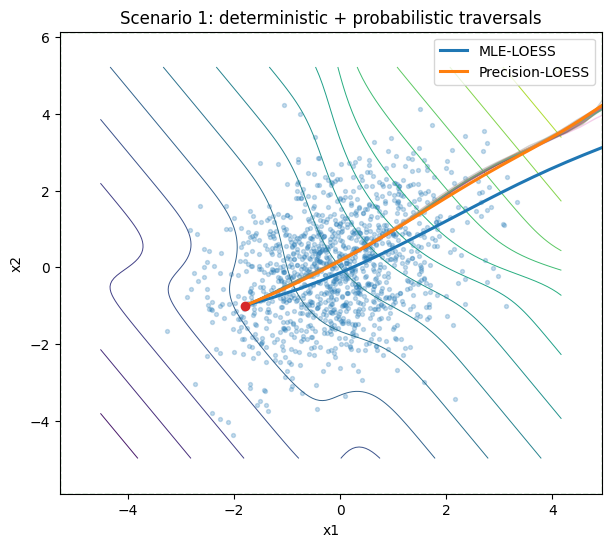

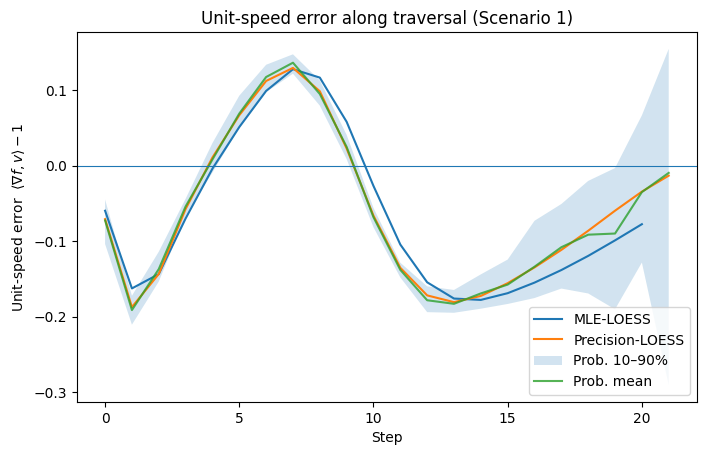

MLE: mean=-0.066, std= 0.100, median abs= 0.117
Precision: mean=-0.061, std= 0.097, median abs= 0.105
Probabilistic mean: mean=-0.062, std= 0.099, median abs= 0.101


In [27]:
# Run the user's LOESS/precision traversal visualization code, then add two NEW scenarios
# (banana-shaped density + cubic-swirl f; spiral arms + radial-bump f)
# and generate additional plots. No external deps beyond numpy/matplotlib.


import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(10)


# ---------------------- LOESS core ----------------------
def gaussian_kernel(d2_over_h2):
    return np.exp(-0.5 * d2_over_h2)


def loess_local_linear(xq, X, y, h=0.8, ridge=1e-8, robust=False):
    """
    Fit local affine model y ~ a + b^T (x - xq) at query xq with Gaussian weights.
    Returns (a_hat, b_hat, Sigma_b, n_eff, resid_var_hat).
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    xq = np.asarray(xq).reshape(1, -1)

    diffs = X - xq                      # (n, d)
    d2 = np.sum(diffs**2, axis=1)
    w = gaussian_kernel(d2 / (h**2))    # (n,)
    Z = np.hstack([np.ones((X.shape[0], 1)), diffs])  # (n, 1+d)

    Zw = Z * w[:, None]
    A = Z.T @ Zw                        # (1+d, 1+d)
    bvec = Z.T @ (w * y)

    A = A + ridge * np.eye(A.shape[0])
    theta = np.linalg.solve(A, bvec)
    a_hat, b_hat = theta[0], theta[1:]

    y_hat = Z @ theta
    r = y - y_hat
    n_eff = (w.sum()**2) / (np.sum(w**2) + 1e-12)
    dof = max(n_eff - Z.shape[1], 1.0)

    if robust:
        R = (w * r**2)
        middle = Z.T @ (R[:, None] * Z)
        Cov_theta = np.linalg.solve(A, middle) @ np.linalg.solve(A, np.eye(A.shape[0]))
        resid_var_hat = np.sum(w * r**2) / dof
    else:
        resid_var_hat = np.sum(w * r**2) / dof
        Cov_theta = resid_var_hat * np.linalg.inv(A)

    Sigma_b = Cov_theta[1:, 1:]
    return a_hat, b_hat, Sigma_b, n_eff, resid_var_hat


def mle_loess_step(x, X, y, h=0.8, lam=0.0):
    """MLE traversal vector at x using LOESS gradient"""
    _, b_hat, _, _, _ = loess_local_linear(x, X, y, h=h)
    denom = float(np.dot(b_hat, b_hat) + lam)
    if denom <= 1e-12:
        return np.zeros_like(b_hat), b_hat, None
    return b_hat / denom, b_hat, None

def precision_loess_step(x, X, y, h=0.8, lam=0.0, alpha=0.0, jitter=1e-10, robust=False, lam2=0.0):
    """
    Precision-metric traversal with ridge on the gradient covariance:
        Π_α = (Σ_b + α I)^(-1),   v = Π_α b_hat / (b_hat^T Π_α b_hat + λ)

    alpha >= 0 shrinks Σ_b before inversion (better conditioning / stability).
    """
    _, b_hat, Sigma_b, _, _ = loess_local_linear(x, X, y, h=h, robust=robust)
    if Sigma_b is None:
        return np.zeros_like(b_hat), b_hat, None
    d = Sigma_b.shape[0]
    M_alpha = Sigma_b + (alpha + jitter) * np.eye(d)
    try:
        Pi_alpha = np.linalg.inv(M_alpha) + lam2 * np.eye(d)
    except np.linalg.LinAlgError:
        # Fallback: diagonal approx if inversion fails
        Pi_alpha = np.diag(1.0 / np.clip(np.diag(M_alpha), jitter, None))
    denom = float(b_hat.T @ Pi_alpha @ b_hat + lam)
    if denom <= 1e-12:
        return np.zeros_like(b_hat), b_hat, Sigma_b
    return (Pi_alpha @ b_hat) / denom, b_hat, Sigma_b


def sample_gradient_from_loess(x, X, y, h=0.8, robust=True):
    _, b_hat, Sigma_b, _, _ = loess_local_linear(x, X, y, h=h, robust=robust)
    if Sigma_b is None:
        return b_hat, None, b_hat
    try:
        L = np.linalg.cholesky(Sigma_b + 1e-12 * np.eye(Sigma_b.shape[0]))
        z = rng.standard_normal(Sigma_b.shape[0])
        b_samp = b_hat + L @ z
    except np.linalg.LinAlgError:
        b_samp = b_hat.copy()
    return b_hat, Sigma_b, b_samp


def precision_step_from_sampled(b_samp, Sigma_b, lam=0.0, jitter=1e-10):
    if Sigma_b is None:
        denom = float(np.dot(b_samp, b_samp) + lam)
        if denom <= 1e-12:
            return np.zeros_like(b_samp)
        return b_samp / denom
    d = Sigma_b.shape[0]
    Sigma_b_j = Sigma_b + jitter * np.eye(d)
    try:
        Pi = np.linalg.inv(Sigma_b_j)
    except np.linalg.LinAlgError:
        Pi = np.eye(d)
    denom = float(b_samp.T @ Pi @ b_samp + lam)
    if denom <= 1e-12:
        return np.zeros_like(b_samp)
    return (Pi @ b_samp) / denom


# ---------------------- Integrators + diagnostics ----------------------
def integrate_det(x0, field_fn, grad_true, bounds, steps=100, dt=0.2):
    x = x0.copy()
    xs = [x.copy()]
    errors = []
    for _ in range(steps):
        v = field_fn(x)
        g = grad_true(x.reshape(1,-1)).reshape(-1)
        speed_err = float(np.dot(g, v) - 1.0)
        errors.append(speed_err)
        x = x + dt * v
        xs.append(x.copy())
        if (x[0] < bounds[0][0]) or (x[0] > bounds[0][1]) or (x[1] < bounds[1][0]) or (x[1] > bounds[1][1]):
            break
    return np.array(xs), np.array(errors)


def integrate_stochastic(x0, X, y, grad_true, bounds, steps=100, dt=0.2, h=0.8, lam=0.0, n_paths=25):
    out = []
    for _ in range(n_paths):
        x = x0.copy()
        xs = [x.copy()]
        errors = []
        for _ in range(steps):
            b_hat, Sigma_b, b_samp = sample_gradient_from_loess(x, X, y, h=h, robust=True)
            v = precision_step_from_sampled(b_samp, Sigma_b, lam=lam)
            g = grad_true(x.reshape(1,-1)).reshape(-1)
            errors.append(float(np.dot(g, v) - 1.0))
            x = x + dt * v
            xs.append(x.copy())
            if (x[0] < bounds[0][0]) or (x[0] > bounds[0][1]) or (x[1] < bounds[1][0]) or (x[1] > bounds[1][1]):
                break
        out.append((np.array(xs), np.array(errors)))
    return out


# ---------------------- Scenarios (original 3) ----------------------
def scenario1(n=2500, noise=0.25):
    C = np.array([[1.3, 0.5],[0.5, 1.8]])
    X = rng.multivariate_normal([0,0], C, size=n)
    def f(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        z = 0.5*x1*x2
        return x1 + 0.6*x2 + 0.8*np.tanh(z)
    def grad(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        z = 0.5*x1*x2; sech2 = 1.0 - np.tanh(z)**2
        return np.stack([1.0 + 0.8*0.5*x2*sech2, 0.6 + 0.8*0.5*x1*sech2], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Elliptical Gaussian + tanh interaction"


def scenario2(n=2500, noise=0.25):
    C = np.array([[2.0, 1.0],[1.0, 2.0]])
    X = rng.multivariate_normal([0,0], C, size=n)
    def f(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        return 0.8*x1 - 0.2*x2 + 0.7*np.sin(0.8*x1) + 0.5*np.cos(0.6*x2)
    def grad(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        df1 = 0.8 + 0.7*0.8*np.cos(0.8*x1)
        df2 = -0.2 - 0.5*0.6*np.sin(0.6*x2)
        return np.stack([df1, df2], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Isotropic Gaussian + wavy linear"


def scenario3(n=2500, noise=0.25):
    r = np.sqrt(rng.uniform(0.8**2, 2.2**2, size=n))
    theta = rng.uniform(-np.pi, np.pi, size=n)
    X = np.c_[r*np.cos(theta), 0.7*r*np.sin(theta)]
    def f(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0]+1.5, x[:,1]-1
        return 0.4*x1 + 0.15*x2 + 0.25*x1*x2 + 0.2*(x1**2 - x2**2)
    def grad(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        df1 = 0.4 + 0.25*x2 + 0.4*x1
        df2 = 0.15 + 0.25*x1 - 0.4*x2
        return np.stack([df1, df2], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Annulus density + quadratic mix"


# ---------------------- NEW Scenarios (4 & 5) ----------------------
def scenario4(n=2500, noise=0.25):
    # Banana-shaped density: start isotropic Gaussian then warp y += 0.2 x^2
    Z = rng.normal(0, 1.0, size=(n,2))
    X = Z.copy()
    X[:,1] = Z[:,1] + 0.20 * (Z[:,0]**2 - 1.0)  # centered quadratic warp
    # Functional: cubic swirl + linear
    def f(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        return 0.7*x1 - 0.3*x2 + 0.10*(x1**3 - 3*x1*x2**2)
    def grad(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        df1 = 0.7 + 0.10*(3*x1**2 - 3*x2**2)
        df2 = -0.3 + 0.10*(-6*x1*x2)
        return np.stack([df1, df2], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Banana density + cubic swirl f"


def scenario5(n=2500, noise=0.25):
    # Two-armed spiral density
    u = rng.uniform(0.0, 1.0, size=n)
    theta = 4.0*np.pi*u + rng.normal(0, 0.15, size=n)
    r = 0.3 + 0.25*theta + rng.normal(0, 0.05, size=n)
    X = np.c_[r*np.cos(theta), r*np.sin(theta)]
    # Functional: radial-bump + angular ripple: f = k1*r + k2*cos(theta) + k3*sin(2*theta)
    k1, k2, k3 = 0.8, 0.6, -0.4
    def f(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        r = np.sqrt(x1**2 + x2**2) + 1e-9
        th = np.arctan2(x2, x1)
        return k1*r + k2*np.cos(th) + k3*np.sin(2*th)
    def grad(x):
        x = np.atleast_2d(x); x1,x2 = x[:,0], x[:,1]
        r2 = x1**2 + x2**2 + 1e-9
        r = np.sqrt(r2)
        th = np.arctan2(x2, x1)
        # ∇r = (x1/r, x2/r); ∇θ = (-x2/r2, x1/r2)
        grad_r = np.stack([x1/r, x2/r], axis=1)
        grad_th = np.stack([-x2/r2, x1/r2], axis=1)
        df = k1*grad_r + (-k2*np.sin(th))[:,None]*grad_th + (2*k3*np.cos(2*th))[:,None]*grad_th
        return df
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Spiral density + radial/angle f"


# ---------------------- Visualization helpers ----------------------
def bounds_from_X(X, margin=0.4, scale=1.2):
    xmin, ymin = X.min(axis=0)
    xmax, ymax = X.max(axis=0)
    cx, cy = (xmin+xmax)/2, (ymin+ymax)/2
    rx, ry = (xmax-xmin)/2*scale, (ymax-ymin)/2*scale
    return ((cx-rx-margin, cx+rx+margin), (cy-ry-margin, cy+ry+margin))


def contour_true(ax, f, X, levels=14):
    xx = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 140)
    yy = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 140)
    GX, GY = np.meshgrid(xx, yy)
    G = np.c_[GX.ravel(), GY.ravel()]
    Z = f(G).reshape(GX.shape)
    ax.contour(GX, GY, Z, levels=levels, linewidths=0.7)


def plot_data(ax, X, max_pts=1200, alpha=0.25, s=8):
    idx = rng.choice(len(X), size=min(max_pts, len(X)), replace=False)
    ax.scatter(X[idx,0], X[idx,1], s=s, alpha=alpha)


# ---------------------- Run original 3-scenario figure ----------------------
h =1.01
lam = 0.
steps = 120*20
dt = 0.5

scenarios = [scenario1(), scenario2(), scenario3()]
# fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)
# for ax, (X, y, f, grad, title) in zip(axes, scenarios):
#     bounds = bounds_from_X(X, margin=0.5, scale=1.2)
#     x0 = np.array([X[:,0].min(), X[:,1].min()]) * 0.5  # start in a lower-left region
#     mle_field = lambda x: mle_loess_step(x, X, y, h=h, lam=lam)[0]
#     prec_field = lambda x: precision_loess_step(x, X, y, h=h, lam=lam)[0]
#     mle_path, _ = integrate_det(x0, mle_field, grad, bounds, steps=steps, dt=dt)
#     prec_path, _ = integrate_det(x0, prec_field, grad, bounds, steps=steps, dt=dt)

#     contour_true(ax, f, X, levels=15)
#     plot_data(ax, X)
#     ax.plot(mle_path[:,0], mle_path[:,1], label="MLE-LOESS", lw=2)
#     ax.plot(prec_path[:,0], prec_path[:,1], label="Precision-LOESS", lw=2)
#     ax.plot([x0[0]],[x0[1]], 'o', ms=5)
#     ax.set_xlim(bounds[0]); ax.set_ylim(bounds[1])
#     ax.set_title(title)
#     ax.set_xlabel("x1"); ax.set_ylabel("x2")
# axes[0].legend(loc="best")
# fig.suptitle("Deterministic traversals across scenarios (ends when leaving bounds)", y=1.04)
# plt.show()


# ---------------------- Unit-speed diagnostics for Scenario 1 ----------------------
X1, y1, f1, grad1, _ = scenarios[0]
bounds1 = bounds_from_X(X1, margin=0.5, scale=1.2)
x0 = np.array([-1.8, -1.0])

mle_field1 = lambda x: mle_loess_step(x, X1, y1, h=h, lam=lam)[0]
prec_field1 = lambda x: precision_loess_step(x, X1, y1, h=h, lam=lam)[0]
mle_path, mle_err = integrate_det(x0, mle_field1, grad1, bounds1, steps=steps, dt=dt)
prec_path, prec_err = integrate_det(x0, prec_field1, grad1, bounds1, steps=steps, dt=dt)

ensemble = integrate_stochastic(x0, X1, y1, grad1, bounds1, steps=steps, dt=dt, h=h, lam=lam, n_paths=20)
max_len = max(len(e[1]) for e in ensemble)
err_mat = np.full((len(ensemble), max_len), np.nan)
for i,(P, E) in enumerate(ensemble):
    err_mat[i,:len(E)] = E
err_mean = np.nanmean(err_mat, axis=0)
err_lo = np.nanpercentile(err_mat, 10, axis=0)
err_hi = np.nanpercentile(err_mat, 90, axis=0)

fig2, ax2 = plt.subplots(figsize=(7,6))
contour_true(ax2, f1, X1, levels=15)
plot_data(ax2, X1)
for P,_ in ensemble:
    ax2.plot(P[:,0], P[:,1], alpha=0.35, lw=1.0)
ax2.plot(mle_path[:,0], mle_path[:,1], lw=2.2, label="MLE-LOESS")
ax2.plot(prec_path[:,0], prec_path[:,1], lw=2.2, label="Precision-LOESS")
ax2.plot([bounds1[0][0], bounds1[0][1], bounds1[0][1], bounds1[0][0], bounds1[0][0]],
         [bounds1[1][0], bounds1[1][0], bounds1[1][1], bounds1[1][1], bounds1[1][0]],
         '--', lw=1.0, alpha=0.6)
ax2.plot([x0[0]],[x0[1]], 'o', ms=6)
ax2.set_xlim(bounds1[0]); ax2.set_ylim(bounds1[1])
ax2.set_title("Scenario 1: deterministic + probabilistic traversals")
ax2.set_xlabel("x1"); ax2.set_ylabel("x2")
ax2.legend(loc="best")
plt.show()

fig3, ax3 = plt.subplots(figsize=(8,4.8))
t_mle = np.arange(len(mle_err))
t_prec = np.arange(len(prec_err))
ax3.plot(t_mle, mle_err, label="MLE-LOESS")
ax3.plot(t_prec, prec_err, label="Precision-LOESS")
ax3.fill_between(np.arange(len(err_mean)), err_lo, err_hi, alpha=0.2, label="Prob. 10–90%")
ax3.plot(np.arange(len(err_mean)), err_mean, alpha=0.8, label="Prob. mean")
ax3.axhline(0.0, lw=0.8)
ax3.set_xlabel("Step")
ax3.set_ylabel(r"Unit-speed error  $\langle \nabla f, v\rangle - 1$")
ax3.set_title("Unit-speed error along traversal (Scenario 1)")
ax3.legend(loc="best")
plt.show()

# Print quick summary stats
def summarize_err(name, e):
    return f"{name}: mean={np.nanmean(e): .3f}, std={np.nanstd(e): .3f}, median abs={np.nanmedian(np.abs(e)): .3f}"

print(summarize_err("MLE", mle_err))
print(summarize_err("Precision", prec_err))
print(summarize_err("Probabilistic mean", err_mean))


# ---------------------- NEW figure: scenarios 4 & 5 ----------------------
# scenarios_new = [scenario4(), scenario5()]
# for (X, y, f, grad, title) in scenarios_new:
#     bounds = bounds_from_X(X, margin=0.5, scale=1.2)
#     x0 = np.array([X[:,0].min(), X[:,1].min()]) * 0.6
#     mle_field = lambda x: mle_loess_step(x, X, y, h=h, lam=lam)[0]
#     prec_field = lambda x: precision_loess_step(x, X, y, h=h, lam=lam)[0]
#     mle_path, _ = integrate_det(x0, mle_field, grad, bounds, steps=steps, dt=dt)
#     prec_path, _ = integrate_det(x0, prec_field, grad, bounds, steps=steps, dt=dt)

#     figN, axN = plt.subplots(figsize=(7,6))
#     contour_true(axN, f, X, levels=15)
#     plot_data(axN, X)
#     axN.plot(mle_path[:,0], mle_path[:,1], lw=2, label="MLE-LOESS")
#     axN.plot(prec_path[:,0], prec_path[:,1], lw=2, label="Precision-LOESS")
#     axN.plot([x0[0]],[x0[1]], 'o', ms=6)
#     axN.set_xlim(bounds[0]); axN.set_ylim(bounds[1])
#     axN.set_title(title)
#     axN.set_xlabel("x1"); axN.set_ylabel("x2")
#     axN.legend(loc="best")
#     plt.show()



In [28]:
# ==================== MORE SCENARIOS (6–15) ====================

def scenario6(n=2500, noise=0.25):
    """Two-moons density + radial/angle functional."""
    m = n//2
    th1 = rng.uniform(0, np.pi, size=m)
    th2 = rng.uniform(0, np.pi, size=n-m)
    r1 = 1.0 + 0.05*rng.standard_normal(m)
    r2 = 1.0 + 0.05*rng.standard_normal(n-m)
    moon1 = np.c_[ r1*np.cos(th1),  r1*np.sin(th1)]
    moon2 = np.c_[ 1.0 - r2*np.cos(th2), -0.2 - 0.9*r2*np.sin(th2)]
    X = np.vstack([moon1, moon2]) + 0.04*rng.standard_normal((n,2))

    k1, k2 = 0.7, 0.5
    def f(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r = np.sqrt(x1**2 + x2**2)+1e-9
        th = np.arctan2(x2, x1)
        return k1*r + k2*np.sin(th)
    def grad(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r2 = x1**2 + x2**2 + 1e-9; r = np.sqrt(r2)
        th = np.arctan2(x2, x1)
        grad_r = np.stack([x1/r, x2/r], axis=1)
        grad_th = np.stack([-x2/r2, x1/r2], axis=1)
        return k1*grad_r + (k2*np.cos(th))[:,None]*grad_th

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Two moons + radial/angle f"


def scenario7(n=2500, noise=0.25):
    """Checkerboard-like mixture of 4 Gaussians + sinusoidal grid functional."""
    centers = np.array([[-2,-2],[2,-2],[-2,2],[2,2]])
    idx = rng.integers(0, len(centers), size=n)
    X = centers[idx] + 0.15*rng.standard_normal((n,2))
    w = 0.9
    def f(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return np.sin(w*x1)*np.cos(w*x2) + 0.3*x1 - 0.1*x2
    def grad(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        df1 = w*np.cos(w*x1)*np.cos(w*x2) + 0.3
        df2 = -w*np.sin(w*x1)*np.sin(w*x2) - 0.1
        return np.stack([df1, df2], axis=1)

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "4-Gaussian grid + sin×cos f"


def scenario8(n=2500, noise=0.25):
    """Tilted 'cigar' Gaussian + softplus linear functional (smooth nonlinearity)."""
    C = np.array([[4.0, 3.6],[3.6, 3.3]])  # high colinearity
    X = rng.multivariate_normal([0,0], C, size=n)
    a = np.array([0.7, -0.4]); c1 = 0.2; tau = 1.0  # softplus temperature
    def f(x):
        x=np.atleast_2d(x); s = x@a
        return c1*x[:,0] + tau*np.log1p(np.exp(s/tau))
    def grad(x):
        x=np.atleast_2d(x); s = x@a
        sig = 1/(1+np.exp(-s/tau))
        return np.stack([c1 + sig*a[0], sig*a[1]], axis=1)

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Tilted Gaussian + softplus linear f"


def scenario9(n=2500, noise=0.25):
    """Star rays density (K spokes) + angular harmonic functional."""
    K = 5
    k_idx = rng.integers(0, K, size=n)
    base_angles = 2*np.pi*k_idx/K
    r = rng.uniform(0.3, 3.0, size=n)
    perp = 0.08*rng.standard_normal(n)
    # unit vectors along and perpendicular to the spoke
    ux = np.cos(base_angles); uy = np.sin(base_angles)
    vx = -uy; vy = ux
    X = np.c_[r*ux + perp*vx, r*uy + perp*vy]

    gamma = 0.8
    def f(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r = np.sqrt(x1**2+x2**2)+1e-9; th = np.arctan2(x2,x1)
        return r + gamma*np.cos(K*th)
    def grad(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r2 = x1**2+x2**2 + 1e-9; r = np.sqrt(r2); th = np.arctan2(x2,x1)
        grad_r = np.stack([x1/r, x2/r], axis=1)
        grad_th = np.stack([-x2/r2, x1/r2], axis=1)
        return grad_r + (-gamma*K*np.sin(K*th))[:,None]*grad_th

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Star rays + angular harmonic f"


def scenario10(n=2500, noise=0.25):
    """Two concentric rings + radial cubic functional."""
    m = n//2
    r1 = 1.0 + 0.05*rng.standard_normal(m)
    r2 = 2.0 + 0.07*rng.standard_normal(n-m)
    th1 = rng.uniform(-np.pi, np.pi, size=m)
    th2 = rng.uniform(-np.pi, np.pi, size=n-m)
    ring1 = np.c_[r1*np.cos(th1), 0.8*r1*np.sin(th1)]
    ring2 = np.c_[r2*np.cos(th2), 0.8*r2*np.sin(th2)]
    X = np.vstack([ring1, ring2]) + 0.03*rng.standard_normal((n,2))

    alpha, beta = 0.6, 0.05
    def f(x):
        x=np.atleast_2d(x); r = np.sqrt((x[:,0]-1)**2 + (x[:,1]+1)**2)+1e-9
        return alpha*r + beta*(r**3)
    def grad(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r2 = x1**2+x2**2 + 1e-9; r = np.sqrt(r2)
        coef = alpha + 3*beta*r**2
        return np.stack([coef*x1/r, coef*x2/r], axis=1)

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Concentric rings + radial cubic f"


def scenario11(n=2500, noise=0.25):
    """Crescent 'C' (ring with a gap) + angle-driven functional."""
    r = 2.0 + 0.07*rng.standard_normal(n)
    th = rng.uniform(-np.pi, np.pi, size=n)
    mask = (np.abs(th) > np.pi/4)  # remove central wedge for 'C'
    th = th[mask]; r = r[mask]
    # replenish to n points
    while len(th) < n:
        t = rng.uniform(-np.pi, np.pi, size=n//5)
        keep = (np.abs(t) > np.pi/4)
        th = np.concatenate([th, t[keep]])
        r = np.concatenate([r, (2.0 + 0.07*rng.standard_normal(np.sum(keep)))])
    th = th[:n]; r = r[:n]
    X = np.c_[r*np.cos(th), 0.7*r*np.sin(th)] + 0.03*rng.standard_normal((n,2))

    a1, a2 = 0.5, 0.8
    def f(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r = np.sqrt(x1**2+x2**2)+1e-9; th = np.arctan2(x2,x1)
        return a1*r + a2*np.cos(th)
    def grad(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r2 = x1**2+x2**2 + 1e-9; r = np.sqrt(r2); th = np.arctan2(x2,x1)
        grad_r = np.stack([x1/r, x2/r], axis=1)
        grad_th = np.stack([-x2/r2, x1/r2], axis=1)
        return a1*grad_r + (-a2*np.sin(th))[:,None]*grad_th

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Crescent 'C' + angle functional"


def scenario12(n=2500, noise=0.25):
    """Cross of elongated Gaussians along axes + tanh components functional."""
    # Mixture of two elongated Gaussians
    Cx = np.array([[3.0, 0.0],[0.0, 0.1]])
    Cy = np.array([[0.1, 0.0],[0.0, 3.0]])
    idx = rng.integers(0, 2, size=n)
    X = np.where(idx[:,None]==0,
                 rng.multivariate_normal([0,0], Cx, size=n),
                 rng.multivariate_normal([0,0], Cy, size=n))
    def f(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return np.tanh(x1) + 0.7*np.tanh(0.8*x2)
    def grad(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        sech2 = 1 - np.tanh(x1)**2
        sech2b = 1 - np.tanh(0.8*x2)**2
        return np.stack([sech2, 0.7*0.8*sech2b], axis=1)

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Axis cross + tanh components f"


def scenario13(n=2500, noise=0.25):
    """Heteroskedastic wavy stripe (x2 var depends on x1) + mixed linear/sin functional."""
    x1 = rng.uniform(-3, 3, size=n)
    sigma = 0.1 + 0.25*(1 + np.cos(x1))
    x2 = np.sin(1.2*x1) + sigma*rng.standard_normal(n)
    X = np.c_[x1, x2] + 0.02*rng.standard_normal((n,2))

    def f(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return 0.8*x1 + 0.2*np.sin(0.7*x1) + 0.6*x2
    def grad(x):
        x=np.atleast_2d(x); x1=x[:,0]
        df1 = 0.8 + 0.2*0.7*np.cos(0.7*x1)
        df2 = 0.6*np.ones_like(df1)
        return np.stack([df1, df2], axis=1)

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Heteroskedastic stripe + mixed f"


def scenario14(n=2500, noise=0.25):
    """Pinwheel density (rotation depends on radius) + linear+radial functional."""
    r = 1.5 + 0.4*rng.standard_normal(n)
    th = rng.uniform(-np.pi, np.pi, size=n)
    base = np.c_[r*np.cos(th), r*np.sin(th)]
    kappa = 0.6
    ang = kappa*r
    ca, sa = np.cos(ang), np.sin(ang)
    X = np.c_[ ca*base[:,0] - sa*base[:,1], sa*base[:,0] + ca*base[:,1] ] + 0.05*rng.standard_normal((n,2))

    a, b = 0.5, -0.3
    def f(x):
        x=np.atleast_2d(x); r = np.sqrt((x**2).sum(axis=1))+1e-9
        return a*x[:,0] + b*x[:,1] + 0.2*r
    def grad(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r = np.sqrt(x1**2+x2**2)+1e-9
        return np.stack([a + 0.2*x1/r, b + 0.2*x2/r], axis=1)

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Pinwheel + linear/radial f"


def scenario15(n=2500, noise=0.25):
    """XOR-ish four clusters + saddle functional."""
    centers = np.array([[-1.6,-1.6],[1.6,1.6],[-1.6,1.6],[1.6,-1.6]])
    idx = rng.integers(0, len(centers), size=n)
    X = centers[idx] + 0.2*rng.standard_normal((n,2))
    def f(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return x1*x2
    def grad(x):
        x=np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return np.stack([x2, x1], axis=1)

    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "XOR clusters + saddle f"


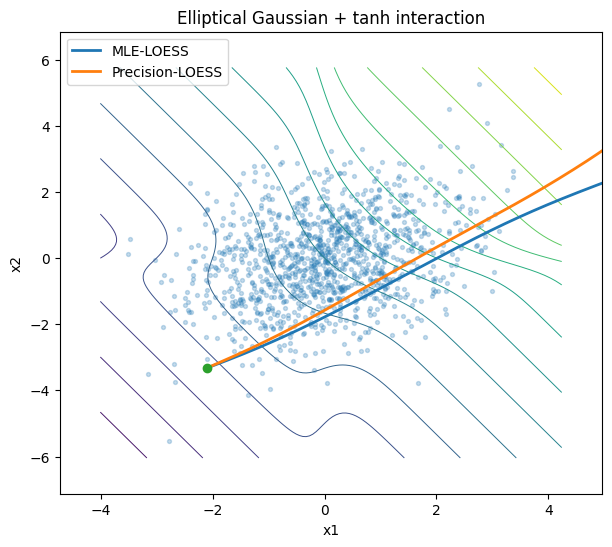

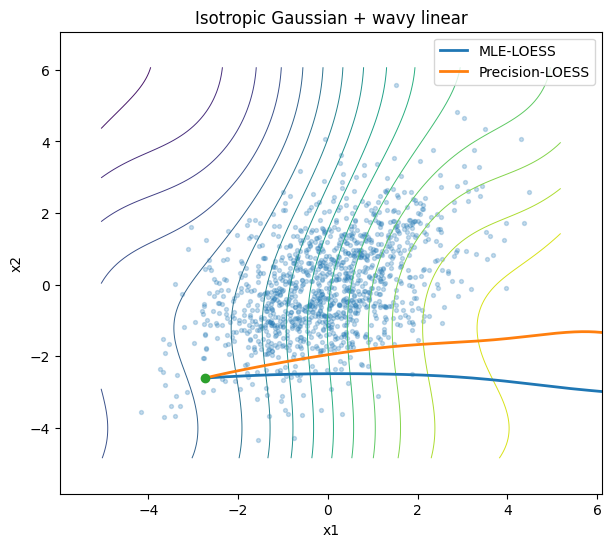

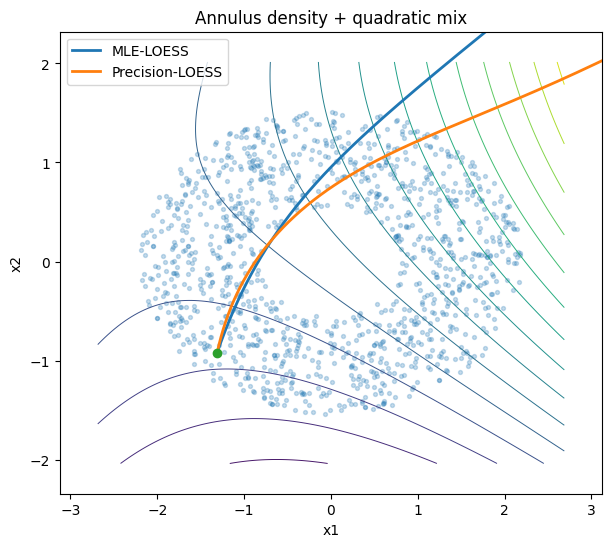

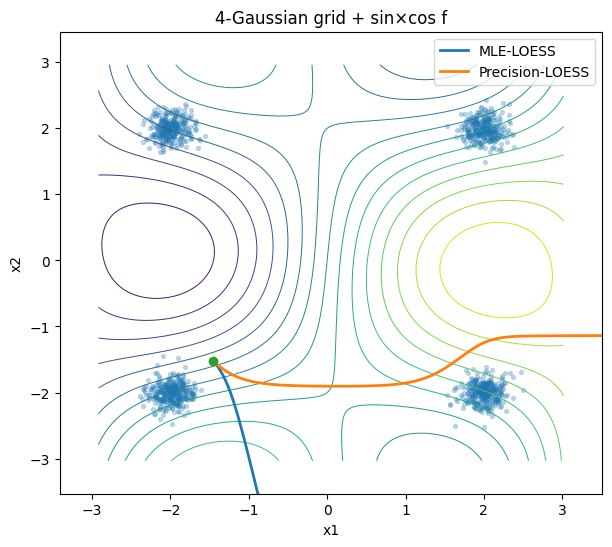

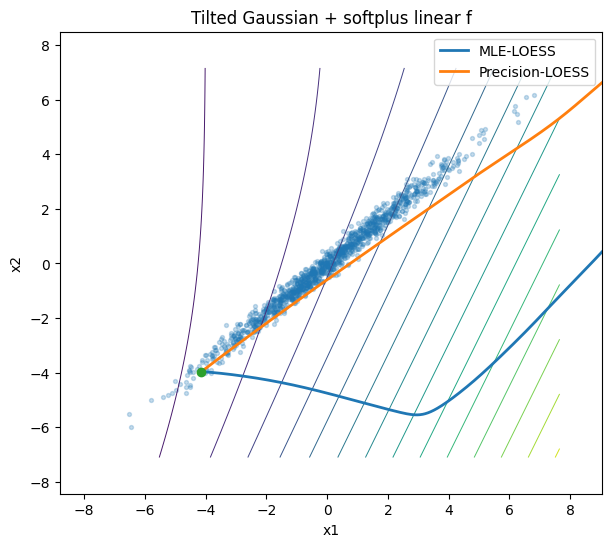

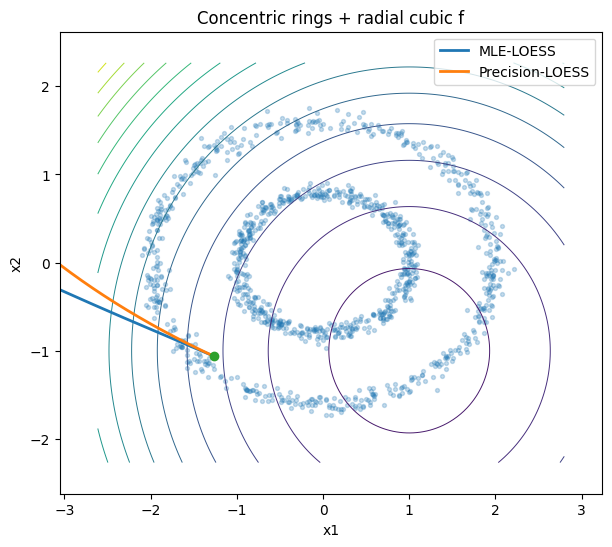

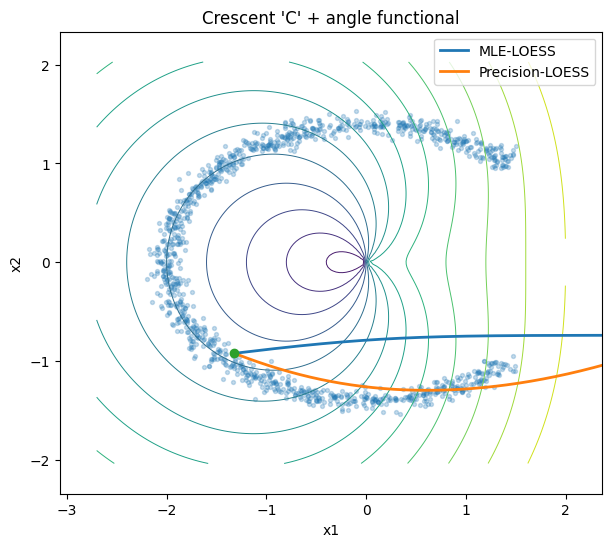

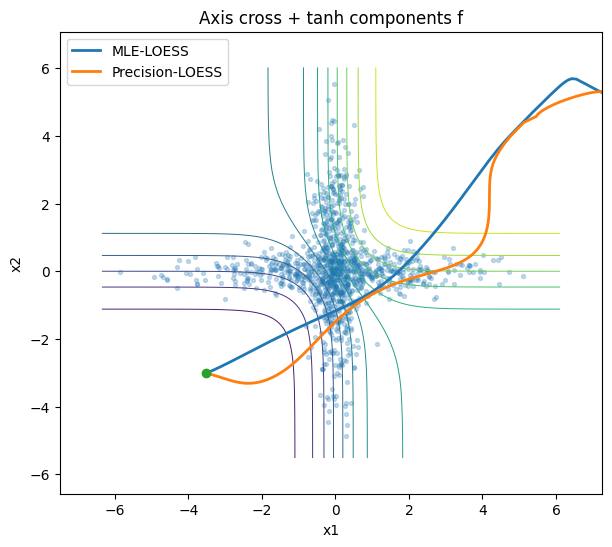

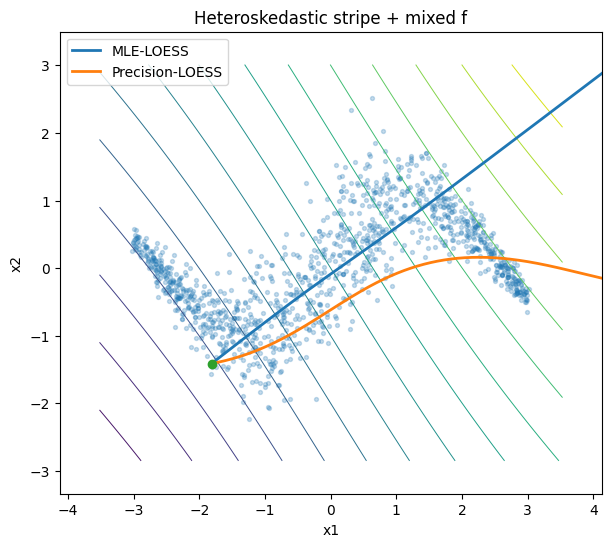

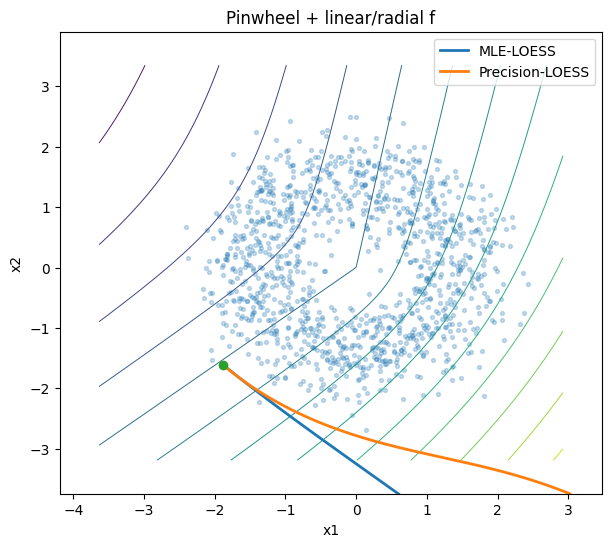

In [29]:

scenarios = [
    scenario1(), scenario2(), scenario3(),  # your originals
    # scenario6(), 
    scenario7(), scenario8(),
    # scenario9(), 
    scenario10(), scenario11(),
    scenario12(), scenario13(), scenario14(), 
    # scenario15(),
]
# ---------------------- NEW figure: scenarios 4 & 5 ----------------------
for (X, y, f, grad, title) in scenarios:
    for a, lam in [(0.00 , .0)]:
        bounds = bounds_from_X(X, margin=0.5, scale=1.2)
        x0 = np.array([X[:,0].min(), X[:,1].min()]) * 0.6
        mle_field = lambda x: mle_loess_step(x, X, y*100, h=h, lam=lam)[0]
        prec_field = lambda x: precision_loess_step(x, X, y*100, h=h, lam=lam, alpha=a)[0]
        mle_path, _ = integrate_det(x0, mle_field, grad, bounds, steps=steps, dt=dt)
        prec_path, _ = integrate_det(x0, prec_field, grad, bounds, steps=steps, dt=dt)

        figN, axN = plt.subplots(figsize=(7,6))
        contour_true(axN, f, X, levels=15)
        plot_data(axN, X)
        axN.plot(mle_path[:,0], mle_path[:,1], lw=2, label="MLE-LOESS")
        axN.plot(prec_path[:,0], prec_path[:,1], lw=2, label="Precision-LOESS")
        axN.plot([x0[0]],[x0[1]], 'o', ms=6)
        axN.set_xlim(bounds[0]); axN.set_ylim(bounds[1])
        axN.set_title(title)
        axN.set_xlabel("x1"); axN.set_ylabel("x2")
        axN.legend(loc="best")
        plt.show()



In [14]:
# ---------------------- Scenarios 6–15 ----------------------

def scenario6(n=2500, noise=0.25):
    # Gaussian mixture (3 elliptic components) + cubic ridge along a tilted axis
    means = np.array([[2.0, 0.4], [-2.0, -0.8], [0.0, 2.2]])
    covs = [
        np.array([[1.0, 0.6],[0.6, 0.9]]),
        np.array([[0.8, -0.5],[-0.5, 1.4]]),
        np.array([[1.2, 0.0],[0.0, 0.5]]),
    ]
    mix = rng.choice(3, size=n, p=[0.35, 0.35, 0.30])
    X = np.vstack([rng.multivariate_normal(means[k], covs[k]) for k in mix])

    # f(x) = α (u·x)^3 + β (v·x)
    phi = 0.7
    u = np.array([np.cos(phi), np.sin(phi)])
    v = np.array([np.cos(-0.4), np.sin(-0.4)])
    alpha, beta = 0.05, 0.8
    def f(x):
        x = np.atleast_2d(x); s = x @ u; t = x @ v
        return alpha*(s**3) + beta*t
    def grad(x):
        x = np.atleast_2d(x); s = x @ u
        return (3*alpha*(s**2))[:,None]*u + beta*v
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "GMM (3 components) + cubic ridge"


def scenario7(n=2500, noise=0.22):
    # Two crescents ("two moons") + wavy valley
    m = n//2
    theta1 = rng.uniform(0, np.pi, size=m)
    theta2 = rng.uniform(0, np.pi, size=n-m)
    r_noise = rng.normal(0, 0.05, size=n)
    A = np.c_[np.cos(theta1), np.sin(theta1)] * (1.8 + r_noise[:m,None])
    B = np.c_[1.0 - np.cos(theta2), -np.sin(theta2)] * (1.8 + r_noise[m:,None]) + np.array([0.2, -0.1])
    X = np.vstack([A, B])

    # f(x) = (x1 - 0.5)^2 - 0.6 cos(1.1 x2)
    def f(x):
        x = np.atleast_2d(x); x1, x2 = x[:,0], x[:,1]
        return (x1-0.5)**2 - 0.6*np.cos(1.1*x2)
    def grad(x):
        x = np.atleast_2d(x); x1, x2 = x[:,0], x[:,1]
        df1 = 2*(x1-0.5)
        df2 = 0.6*1.1*np.sin(1.1*x2)
        return np.stack([df1, df2], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Two crescents + wavy valley"


def scenario8(n=2500, noise=0.2):
    # Checkerboard of Gaussian bumps + angle/radius functional
    centers = []
    for i in range(-2,3):
        for j in range(-2,3):
            if (i + j) % 2 == 0:
                centers.append([1.0*i, 1.0*j])
    centers = np.array(centers)
    idx = rng.integers(0, len(centers), size=n)
    base = centers[idx]
    X = base + rng.normal(0, 0.25, size=(n,2))

    k1, k2 = 0.9, 0.6
    eps = 1e-9
    def f(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r = np.sqrt(x1**2 + x2**2) + eps
        th = np.arctan2(x2, x1)
        return k1*th + k2*r
    def grad(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r2 = x1**2 + x2**2 + eps; r = np.sqrt(r2)
        grad_r = np.stack([x1/r, x2/r], axis=1)
        grad_th = np.stack([-x2/r2, x1/r2], axis=1)
        return k1*grad_th + k2*grad_r
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Checkerboard bumps + angle/radius f"


def scenario9(n=2500, noise=0.25):
    # Concentric rings (3 radii) + radial oscillations with angular ripple
    radii = np.array([1.0, 1.6, 2.2])
    comp = rng.choice(3, size=n, p=[0.34, 0.33, 0.33])
    r = radii[comp] + rng.uniform(-0.08, 0.08, size=n)
    th = rng.uniform(-np.pi, np.pi, size=n)
    X = np.c_[r*np.cos(th), 0.8*r*np.sin(th)]

    k1, k2, k3 = 0.8, 0.5, 0.3
    eps = 1e-9
    def f(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r = np.sqrt(x1**2+x2**2) + eps
        th = np.arctan2(x2,x1)
        return k1*r + k2*np.sin(3*r) + k3*np.cos(2*th)
    def grad(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r2 = x1**2+x2**2 + eps; r = np.sqrt(r2); th = np.arctan2(x2,x1)
        grad_r = np.stack([x1/r, x2/r], axis=1)
        grad_th = np.stack([-x2/r2, x1/r2], axis=1)
        return (k1 + 3*k2*np.cos(3*r))[:,None]*grad_r + (-2*k3*np.sin(2*th))[:,None]*grad_th
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Concentric rings + radial oscillations"


def scenario10(n=2500, noise=0.25):
    # Pinwheel density (5 arms)
    K = 5
    kk = rng.integers(0, K, size=n)
    base_angle = kk * (2*np.pi/K)
    r = rng.normal(2.0, 0.35, size=n).clip(0.2, None)
    twist = 0.9 * r
    th = base_angle + twist + rng.normal(0, 0.18, size=n)
    X = np.c_[r*np.cos(th), r*np.sin(th)]
    X[:,1] *= 0.75  # anisotropy

    # Rotated quadratic bowl: f = 0.5 x^T Q x + a^T x
    ang = 0.5
    R = np.array([[np.cos(ang), -np.sin(ang)],[np.sin(ang), np.cos(ang)]])
    D = np.diag([1.0, 0.35])
    Q = R.T @ D @ R
    a = np.array([0.2, -0.1])
    def f(x):
        x = np.atleast_2d(x)
        return 0.5*np.sum((x @ Q)*x, axis=1) + x @ a
    def grad(x):
        x = np.atleast_2d(x)
        return x @ (Q + Q.T)/2 + a  # Q symmetric anyway
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Pinwheel density + rotated quadratic"


def scenario11(n=2500, noise=0.22):
    # Funnel-shaped density: var(x2 | x1) grows with x1
    x1 = rng.normal(0, 1.2, size=n)
    sig = np.exp(0.6 * x1)
    x2 = rng.normal(0, sig)
    X = np.c_[x1, x2]

    # f(x) = σ(x1) + x2^2 / (2*(c + sqrt(x1^2 + eps)))  (σ is logistic)
    c, eps = 0.5, 1e-6
    def f(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        sigm = 1/(1+np.exp(-x1))
        denom = c + np.sqrt(x1**2 + eps)
        return sigm + 0.5*(x2**2)/denom
    def grad(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        sigm = 1/(1+np.exp(-x1))
        dsigm = sigm*(1-sigm)
        denom = c + np.sqrt(x1**2 + eps)
        ddenom_dx1 = x1/np.sqrt(x1**2 + eps)
        df1 = dsigm - 0.5*(x2**2)*(ddenom_dx1)/(denom**2)
        df2 = x2/denom
        return np.stack([df1, df2], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Funnel density + logistic/rational f"


def scenario12(n=2500, noise=0.2):
    # Cross-shaped density: two thick bars (horizontal & vertical)
    m = n//2
    xh = rng.uniform(-2.5, 2.5, size=m)
    yh = rng.normal(0, 0.15, size=m)
    xv = rng.normal(0, 0.15, size=n-m)
    yv = rng.uniform(-2.5, 2.5, size=n-m)
    X = np.vstack([np.c_[xh, yh], np.c_[xv, yv]])

    # f(x) = sqrt((x·u)^2 + eps) + γ sin(w (x·v))
    eps = 1e-3; w = 1.2; gamma = 0.5
    ang = 0.35
    u = np.array([np.cos(ang), np.sin(ang)])
    v = np.array([np.cos(ang+np.pi/2), np.sin(ang+np.pi/2)])
    def f(x):
        x = np.atleast_2d(x); s = x @ u; t = x @ v
        return np.sqrt(s**2 + eps) + gamma*np.sin(w*t)
    def grad(x):
        x = np.atleast_2d(x); s = x @ u; t = x @ v
        ds = (s/np.sqrt(s**2+eps))[:,None] * u
        dt = (gamma*w*np.cos(w*t))[:,None] * v
        return ds + dt
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Cross density + ridge+wave f"


def scenario13(n=2500, noise=0.22):
    # Square ring (box annulus) density
    a, b = 2.4, 1.1   # outer/inner half-width
    X = []
    while len(X) < n:
        pts = rng.uniform(-a, a, size=(n,2))
        mask = np.logical_or(np.abs(pts).max(axis=1) > b, np.abs(pts).max(axis=1) < a)  # outside inner box
        pts = pts[mask][:max(0, n-len(X))]
        X.append(pts)
    X = np.vstack(X)[:n] + rng.normal(0, 0.04, size=(n,2))

    # f(x) = tanh(ax1) + tanh(bx2) + 0.2 x1 x2
    a1, b1 = 0.9, 0.7
    def f(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return np.tanh(a1*x1) + np.tanh(b1*x2) + 0.2*x1*x2
    def grad(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        sech2_1 = 1 - np.tanh(a1*x1)**2
        sech2_2 = 1 - np.tanh(b1*x2)**2
        df1 = a1*sech2_1 + 0.2*x2
        df2 = b1*sech2_2 + 0.2*x1
        return np.stack([df1, df2], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Square ring + tanh+saddle mix"


def scenario14(n=2500, noise=0.2):
    # Flower/rosette: r = r0 + amp*cos(mθ) + noise
    m = 5
    th = rng.uniform(-np.pi, np.pi, size=n)
    r = 1.6 + 0.35*np.cos(m*th) + rng.normal(0, 0.08, size=n)
    X = np.c_[r*np.cos(th), r*np.sin(th)]

    c1, c2 = 0.6, 0.7
    eps = 1e-9
    def f(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return x2
    def grad(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        r2 = x1**2+x2**2+eps; r=np.sqrt(r2); th=np.arctan2(x2,x1)
        grad_r = np.stack([x1/r, x2/r], axis=1)
        grad_th = np.stack([-x2/r2, x1/r2], axis=1)
        return (-c1*m*np.sin(m*th))[:,None]*grad_th + c2*grad_r
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "Rosette density + θ-harmonic + radial"


def scenario15(n=2500, noise=0.2):
    # S-curve density along y ≈ α tanh(β x) + γ x with noise
    alpha, beta, gamma = 1.2, 0.9, 0.3
    x1 = rng.uniform(-2.5, 2.5, size=n)
    mean_y = alpha*np.tanh(beta*x1) + gamma*x1
    x2 = mean_y + rng.normal(0, 0.2, size=n)
    X = np.c_[x1, x2]

    # f(x) = x1 + 0.5 sin(1.5 x1) + 0.3 x2
    def f(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        return x1 + 0.5*np.sin(1.5*x1) + 0.3*x2
    def grad(x):
        x = np.atleast_2d(x); x1,x2=x[:,0],x[:,1]
        df1 = 1.0 + 0.5*1.5*np.cos(1.5*x1)
        df2 = 0.3
        return np.stack([df1, np.full_like(df1, df2)], axis=1)
    y = f(X) + rng.normal(0, noise, size=n)
    return X, y, f, grad, "S-curve density + phase-warped linear f"


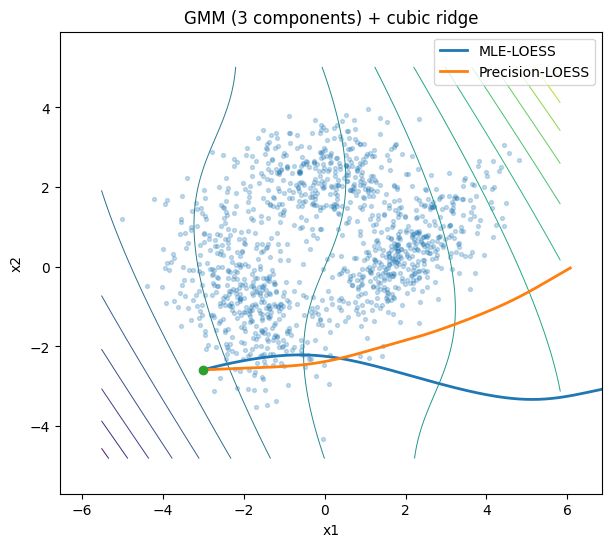

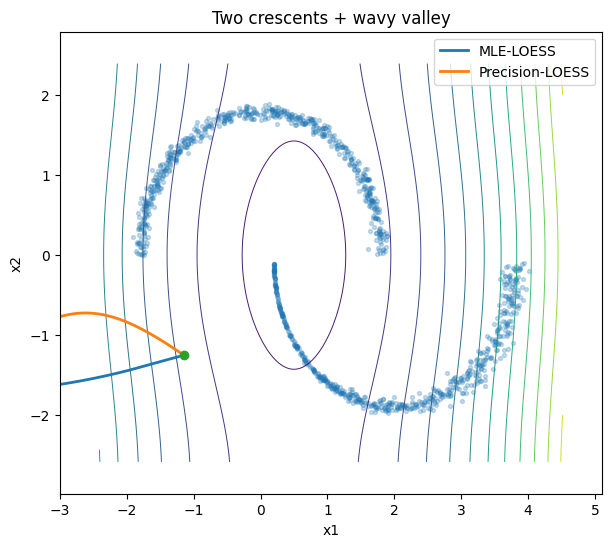

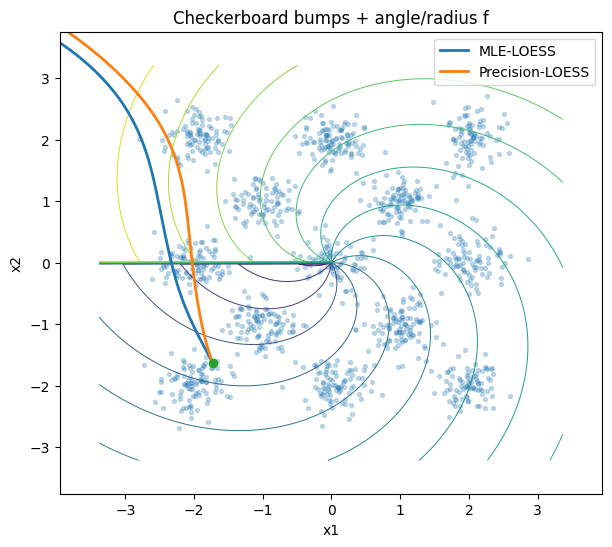

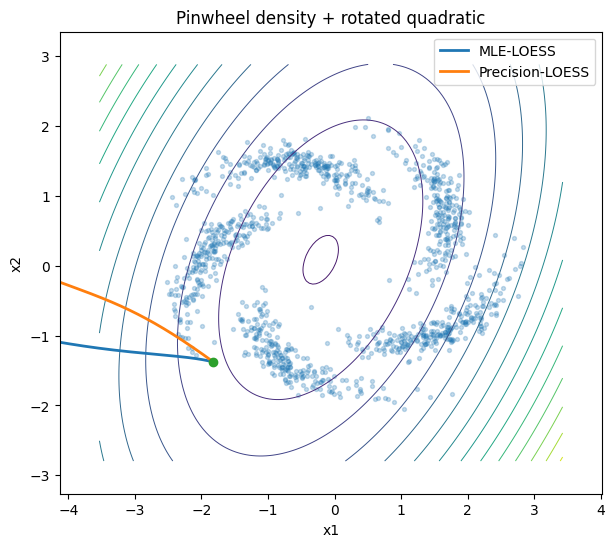

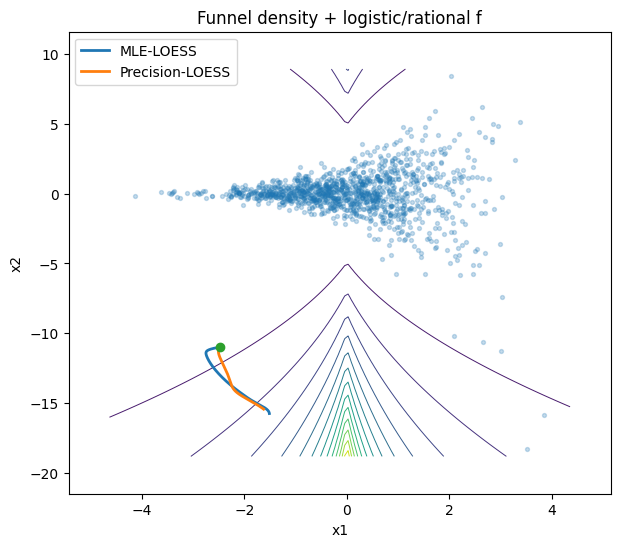

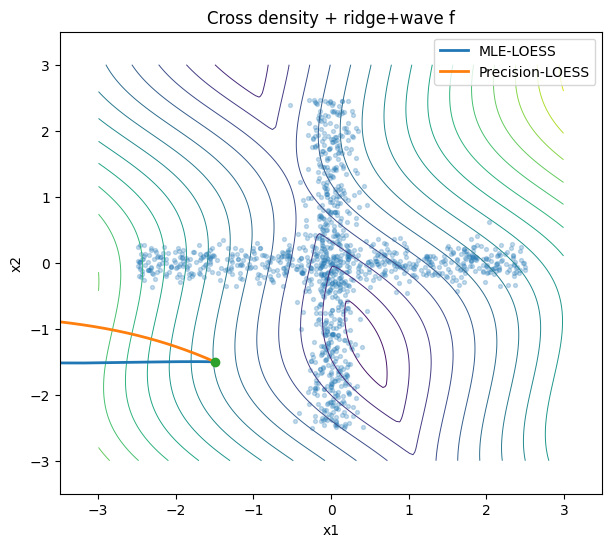

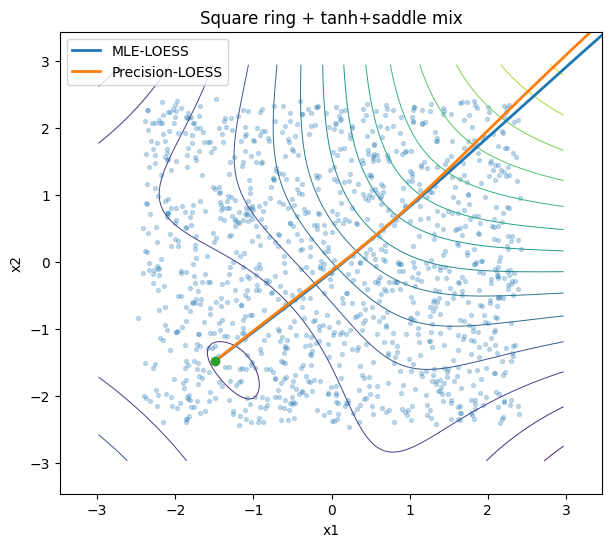

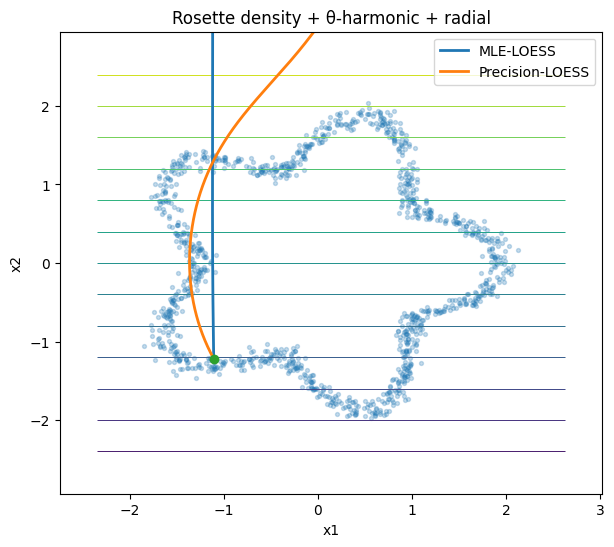

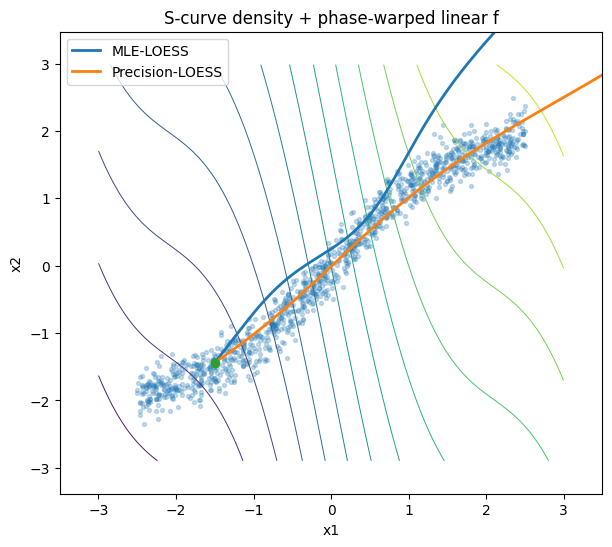

In [ ]:

# Extend the deterministic 3-panel figure
scenarios = [scenario1(), scenario3(), scenario9()]   # e.g., donut + concentric rings

# Or build a new grid
more = [scenario6(), scenario7(), scenario8(), scenario10(), scenario11(),
        scenario12(), scenario13(), scenario14(), scenario15()]

# ---------------------- NEW figure: scenarios 4 & 5 ----------------------
for (X, y, f, grad, title) in more:
    for lam in [0. ]:
        bounds = bounds_from_X(X, margin=0.5, scale=1.2)
        x0 = np.array([X[:,0].min(), X[:,1].min()]) * 0.6
        mle_field = lambda x: mle_loess_step(x, X, y*100, h=h, lam=lam)[0]
        prec_field = lambda x: precision_loess_step(x, X, y*100, h=h, lam=lam)[0]
        mle_path, _ = integrate_det(x0, mle_field, grad, bounds, steps=steps, dt=dt)
        prec_path, _ = integrate_det(x0, prec_field, grad, bounds, steps=steps, dt=dt)

        figN, axN = plt.subplots(figsize=(7,6))
        contour_true(axN, f, X, levels=15)
        plot_data(axN, X)
        axN.plot(mle_path[:,0], mle_path[:,1], lw=2, label="MLE-LOESS")
        axN.plot(prec_path[:,0], prec_path[:,1], lw=2, label="Precision-LOESS")
        axN.plot([x0[0]],[x0[1]], 'o', ms=6)
        axN.set_xlim(bounds[0]); axN.set_ylim(bounds[1])
        axN.set_title(title)
        axN.set_xlabel("x1"); axN.set_ylabel("x2")
        axN.legend(loc="best")
        plt.show()



In [ ]:
import pandas as pd
from traversal_sim import run_simulation
from traversal_sim import (
    plot_traversal_heatmap, plot_prediction_curve, plot_traversal_curve
)

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import torch
from typing import List, Dict, Sequence, Tuple, Iterable, Union, Optional


# True linear model
class TrueLinear(torch.nn.Module):
    def __init__(self, w, b=0.0):
        super().__init__()
        self.w = torch.nn.Parameter(w.clone().detach(), requires_grad=False)
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=w.dtype, device=w.device), requires_grad=False)

    def forward(self, X):
        return X @ self.w + self.b

# Build a challenging X distribution
d = 64
X_dist = ChallengingGaussian(dim=d, colinearity=0.8, coskewness=0.5, total_variance=1.0, seed=42)
w_true = torch.linspace(1.0, 1.6, d, dtype=torch.float64)
f_true = TrueLinear(w_true)


out = run_simulation(
    X_dist=X_dist,
    f_true=f_true,
    lambdas=[0.0, 0.01, 0.05, 0.1, 0.2, 0.5],            # model ridge penalties
    epsilons=np.array([0.0, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1,])*100,    # traversal penalties
    n_train=256, n_test=3000, n_sims=32,
    noise_std=0.3,
    seed=123,
)

pred_df = pd.DataFrame(out["pred_summary"])
trav_df = pd.DataFrame(out["traversal_summary"])

# ---------- Plotting helpers (Plotly figures) ----------

def plot_traversal_heatmap(
    traversal_summary: Union[pd.DataFrame, Iterable[Dict]],
    value_col: str = "mse_mean",
    lambda_col: str = "lambda",
    epsilon_col: str = "epsilon",
    title: str = "Traversal MSE = Error of unit increase step",
    log_x: bool = False,
    log_y: bool = False,
    log_error: bool = False,
) -> go.Figure:
    """
    Build a 2D heatmap (lambda x epsilon) of traversal MSE using Plotly.
    traversal_summary: DataFrame or records with at least [lambda, epsilon, value_col].
    """
    df = pd.DataFrame(traversal_summary).copy()
    # Ensure numeric types
    df[lambda_col] = pd.to_numeric(df[lambda_col])
    df[epsilon_col] = pd.to_numeric(df[epsilon_col])
    df[value_col]   = pd.to_numeric(df[value_col])
    # Pivot to matrix
    mat = df.pivot(index=lambda_col, columns=epsilon_col, values=value_col).sort_index().sort_index(axis=1)
    # Set default Plotly width/height (in px)
    default_width, default_height = 700, 450
    # mat.shape: (n_rows, n_cols)
    n_rows, n_cols = mat.shape
    max_n = max(n_rows, n_cols)
    cell_width, cell_height = 700/max_n, 700/max_n
    mat_width = n_cols * cell_width
    mat_height = n_rows * cell_height
    fig_width = int((default_width + mat_width) / 2)
    fig_height = int((default_height + mat_height) / 2)
    if log_error:
        mat_values = -np.exp(-1/2*mat.values**0.5)
    else:
        mat_values = mat.values
    fig = px.imshow(mat_values,
                    x=[f"{c:g}" for c in mat.columns],
                    y=[f"{r:g}" for r in mat.index],
                    aspect="auto",
                    labels=dict(x="epsilon (traversal ridge)", y="lambda (model ridge)", color=value_col),
                    title=title,
                    width=fig_width,
                    height=fig_height)
                
    # Optional log ticks (display only; the values plotted are linear MSEs)
    if log_x:
        fig.update_xaxes(type="category", title="epsilon (log grid)")
    if log_y:
        fig.update_yaxes(type="category", title="lambda (log grid)")
    return fig

fig_heat = plot_traversal_heatmap(trav_df, value_col="mse_mean", log_error=True)
# fig_pred = plot_prediction_curve(pred_df, metric="mse")
# fig_trav = plot_traversal_curve(trav_df, lambda_value=0.3, value_col="mse_mean")

# # Save or show:
fig_heat.show()
# fig_pred.show()
# fig_trav.show()


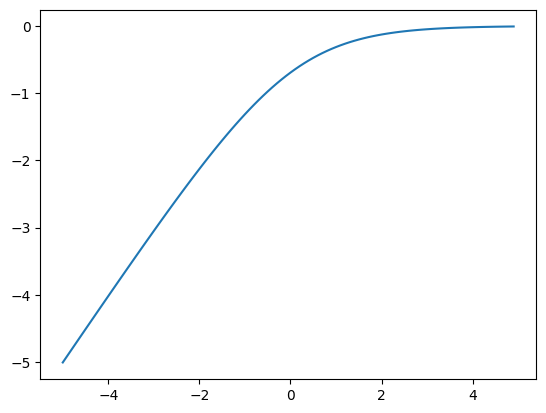

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import torch

x= (torch.arange(100)-50)/10
x_sigmoid = torch.sigmoid(x)
x_s_log = torch.log(x_sigmoid)
plt.plot(x, x_s_log)